# Test model viz

Can we specify a model visualization that lacks the difficulties of bending matplotlib to the task? Let's see how writing SVG with [svgwrite](https://github.com/mozman/svgwrite) ([docs here](https://svgwrite.readthedocs.io/en/master/index.html)) works out. If this works, our end goal would be full svg representation of the model which would incidently give us a means of tieing into ipython's [rich display systems](https://ipython.readthedocs.io/en/stable/config/integrating.html).

A useful reference when writing this was [a list of named colors](https://www.december.com/html/spec/colorsvg.html). Various [svg tutorials](https://flaviocopes.com/svg/#path) were of some aid.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import svgwrite

showsvg = lambda svg: SVG(svg.tostring())

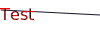

In [2]:
svg = svgwrite.Drawing(profile="Tiny", size=("100", "50"))
svg.add(svg.line((1, 10), (200, 20), stroke=svgwrite.rgb(10, 10, 16, '%')))
test_text = svg.add(svg.text('Test', insert=(0, 20), fill='red'))
showsvg(svg)

What does that look like raw?

In [3]:
svg.tostring()

'<svg baseProfile="tiny" height="50" version="1.2" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><line stroke="rgb(10%,10%,16%)" x1="1" x2="200" y1="10" y2="20" /><text fill="red" x="0" y="20">Test</text></svg>'

And is it modifiable? 

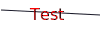

In [4]:
test_text.attribs['x'] = 30
showsvg(svg)

What I get from this is that attibutes of svg components can be natively modified and re-rendered or displayed. So you can either re-generate the svg at each time point or alter it on a timestep by timestep basis. 

What do we want a model visualization to look like with this approach? Let's look at a mockup:

![Mockup](./model_mockup.png)

What we have are:
 - in black: a series of tracts
 - in blue: actin filaments
 - in green: $\alpha$-actinin links to adjacent tracts, currently not showing x-dir offset
 - in gray: anchors that are fixing actin filament ends
 
In order to have each of those pieces I need to be able to return svg representations of each of the objects of interest, group them, translate the group to a tract location in the document coordinates, and then apply per-tract masking in order to not have things overflow from each tract into its neighbors.

Let's explore the ability to create, add to, style, and transform groups. 

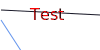

In [5]:
group = svg.add(svg.g(id='test_group', stroke='cornflowerblue'))
group.add(svg.line((1,20), (40,80)))
showsvg(svg)

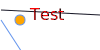

In [6]:
group.add(svg.circle((20,20), 5, fill='orange'))
showsvg(svg)

Can we define a style and then reuse it? This would make it easier to implement a common look across elements by type.

In [7]:
dwg = svgwrite.Drawing(profile="Full", size=("100", "50"))
dwg.add(dwg.style("stroke:cornflowerblue; fill:white"))
dwg.tostring()

'<svg baseProfile="full" height="50" version="1.1" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><style type="text/css"><![CDATA[stroke:cornflowerblue; fill:white]]></style></svg>'

That isn't what we want to do. It is an embedding of a CSS style within an element and requires the `Full` svg profile in order to implement it (as it counts as a scripting call. I think that `defs` might be what we want to use based on [this](https://developer.mozilla.org/en-US/docs/Web/SVG/Element/defs).

<svg baseProfile="tiny" height="50" version="1.2" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs><line id="actin" x1="0" x2="0" y1="0" y2="0" /></defs><line id="actin" x1="0" x2="0" y1="0" y2="0" /></svg>


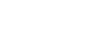

In [8]:
dwg = svgwrite.Drawing(profile="Tiny", size=("100", "50"))
dwg.add(dwg.defs.add(dwg.line(id='actin')))#, stroke=svgwrite.rgb(10, 10, 16, '%'))))
dwg.use('actin', (1,10))#, (100,40))
#svg.add(svg.line((1, 10), (200, 20), stroke=svgwrite.rgb(10, 10, 16, '%')))
#test_text = svg.add(svg.text('Test', insert=(0, 20), fill='red'))
print(dwg.tostring())
showsvg(dwg)

Turns out `def`s let us set the insertion location, width, and height of the element but not attributes like start and end. This means that we can't vary line length through the use of defs and thus won't find them to be of much use. 

We could explore the use of paths, but I think we're getting into some more complicated territory. The best route forward might be to let each line have a representation at `y=0` and translate them to the proper (random) y location. Let's see how the translation interface (added as mixins to each class so uniform?) work. 

<svg baseProfile="tiny" height="50" version="1.2" width="100" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><line stroke="rgb(10%,10%,16%)" transform="translate(0,20)" x1="0" x2="100" y1="0" y2="0" /></svg>


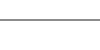

In [9]:
dwg = svgwrite.Drawing(profile="Tiny", size=("100", "50"))
l = dwg.add(dwg.line((0,0),(100,0), stroke=svgwrite.rgb(10, 10, 16, '%')))
l.translate(0, 20)
print(dwg.tostring())
showsvg(dwg)

Ok, I like that more. I'm going to try two things now:
1. See how painful it is to switch back to CSS styling for a centralized control.  
2. Create a group for a tract, populate it, and translate the whole thing.

In [10]:
# Trying CSS styling again, since it looks like what we want to do in the longer term
CSS_STYLES = """
    .background { background-color: oldlace; }
    .actin { stroke: cornflowerblue; stroke-width: 3px; }
    .anchor { stroke: tan; fill: tan;}
    .actinin { stroke: limegreen; fill: limegreen; stroke-width: 2px; }
    .tract { stroke: darkslategray; fill: whitesmoke; stroke-width: 3px; }
    .fade {opacity: 0.3;}
"""

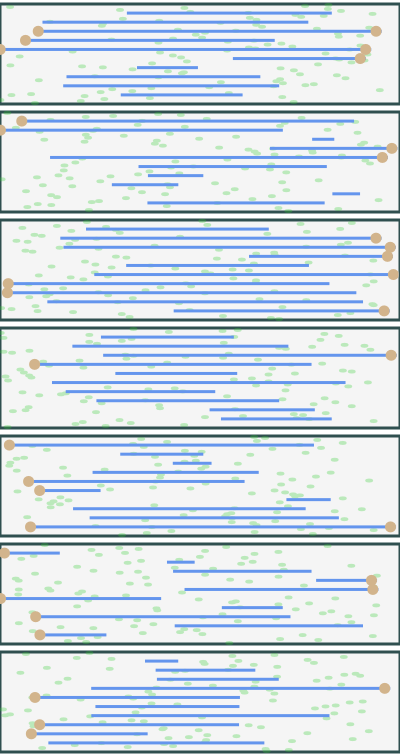

In [11]:
# Set up parameters
x_span = 200

# Set up world
import stress_fiber as sf
w = sf.construct.create_test_world(1, 200, 10, 100)
ts = w.tractspace
t = ts.all_tracts[3]
act = t.mols['actin'][4]
pair = act.pairs[3]
alph = t.mols['actinin'][4]
anc = t.mols['anchor'][0]
#[w.step() for i in range(10)]


## Create plotting functions in external module. These were previously local to this cell but
## have been refactored into their own visualization module. 
                       
import stress_fiber.visualize
dwg = sf.visualize.flat_render.plot_world(w)
#print(dwg.tostring())
showsvg(dwg)

That is a full display of a model. It loads in other graphics programs. We can convert these to PNGs via ImageMagik or similar (`rsvg-convert`) and then to time-lapse movies of the model running as a two line bash script after creation. 

Left off here. Next step is to run the model through multiple time steps, save output each step, convert and weave.